# 卷积神经网络

结构：
    （卷积层+（可选）池化层） * N + 全连接层  * M
    
    分类任务

全卷积神经网络：
    （卷积层 + （可选）池化层） * N + 反卷积层 *  K
    
    物体分割
    

### 卷积操作

神经网络遇到的问题
    参数过多：
        计算资源不足
        容易过拟合（泛化能力差），需要更多训练数据
        
局部连接，参数共享

输出size = 输入size - 卷积核size + 1
padding使输出size不变


### 池化操作

常使用不重叠、不补零
没有用于求导的参数
池化层参数为步长和池化核大小
用于减少图像尺寸，从而减少计算量
一定程度平移鲁棒

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
#x = (x - μ) / std(方差) 符合均值是零，方差是1的正态分布
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
#x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28, 1)

### 卷积神经网络实现

In [4]:
model = keras.models.Sequential()
#添加卷积层
#filters有多少个卷积核
#kernal_size卷积核大小
#padding，是输入输出大小一样
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='selu',input_shape=(28,28,1)))
#第二个卷积层
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='selu'))
#添加池化层,步长和size一般相等
model.add(keras.layers.MaxPool2D(pool_size=2))

#再添加一层，fliters翻倍以防损失
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='selu'))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='selu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

#再添加一层
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='selu'))
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='selu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

#添加全连接层
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation="selu"))
model.add(keras.layers.Dense(10,activation="softmax"))

#relu: y = max（0，x)
#softmax：将向量变成概率分布 x = [x1, x2, x3]
#    y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^X1 + e^x2 + e^x3
#reason for sparse: y->index. y->one)hot->[]
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])

In [5]:
model.summary()#查看模型的架构

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

In [6]:
#Tensorborad， earlystopping， modelcheckpoint
logdir = os.path.join("cnn-selu-callbacks")
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,"fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=10, 
                    validation_data=(x_valid_scaled, y_valid),
                   callbacks=callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 22s 400us/sample - loss: 0.4339 - accuracy: 0.8419 - val_loss: 0.3250 - val_accuracy: 0.8822
Epoch 2/10
55000/55000 [==============================] - 19s 348us/sample - loss: 0.2900 - accuracy: 0.8939 - val_loss: 0.2837 - val_accuracy: 0.9000
Epoch 3/10
55000/55000 [==============================] - 19s 347us/sample - loss: 0.2419 - accuracy: 0.9131 - val_loss: 0.2654 - val_accuracy: 0.9042
Epoch 4/10
55000/55000 [==============================] - 19s 340us/sample - loss: 0.2057 - accuracy: 0.9263 - val_loss: 0.2596 - val_accuracy: 0.9024
Epoch 5/10
55000/55000 [==============================] - 19s 346us/sample - loss: 0.1788 - accuracy: 0.9356 - val_loss: 0.2401 - val_accuracy: 0.9130
Epoch 6/10
55000/55000 [==============================] - 19s 345us/sample - loss: 0.1538 - accuracy: 0.9458 - val_loss: 0.2537 - val_accuracy: 0.9088
Epoch 7/10
55000/55000 [=====================

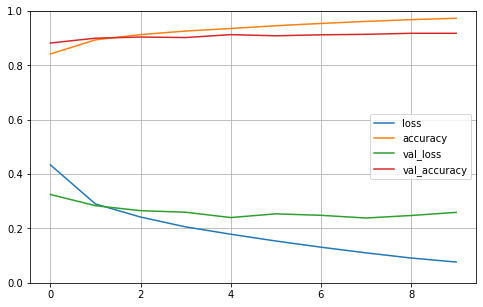

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
plot_learning_curves(history)


In [8]:
#指标评估
model.evaluate(x_test_scaled, y_test)

10000/10000 [==============================] - 2s 184us/sample - loss: 0.2715 - accuracy: 0.9175


[0.27148901503533124, 0.9175]